In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7 #600x600
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
import imgaug.augmenters as iaa
import imgaug

from sklearn.model_selection import train_test_split

2023-02-01 19:38:52.226006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_colwidth', None)
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'
data_dir = 'data'
seed = 42

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_forks = pd.read_csv(data_dir+'/forks_aug.csv', dtype={'Id': str})
df_spoons = pd.read_csv(data_dir+'/spoon_aug.csv', dtype={'Id': str})
df_cups = pd.read_csv(data_dir+'/cup_aug.csv', dtype={'Id': str})
df_glasses = pd.read_csv(data_dir+'/glasses_aug.csv', dtype={'Id': str})
df_knife = pd.read_csv(data_dir+'/knife_aug.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra, df_forks, df_glasses, df_knife, df_spoons, df_cups], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full = df_train_full.sample(frac = 1, random_state = seed)
df_train_full.reset_index(drop = True, inplace = True)
df_train_full.head()

,Id,label,filename
0,4947,spoon,data/images/4947.jpg
1,0057,spoon,data/images/0057.jpg
2,glass_aug_565,glass,data/images/glass_aug_565.jpg
3,fork_aug_725,fork,data/images/fork_aug_725.jpg
4,glass_aug_171,glass,data/images/glass_aug_171.jpg


In [4]:
df_train_full.label.value_counts()

knife    1707
spoon    1702
fork     1702
glass    1700
cup      1700
plate    1698
Name: label, dtype: int64

In [5]:
#df_forks

In [6]:
image_width = 600
image_height = 600
NUM_CLASSES = 6
batch_size = 32

In [7]:
df_train, df_val, y_train, y_val = train_test_split(df_train_full, df_train_full['label'], test_size = 0.2, shuffle = True, stratify = df_train_full['label'], random_state = seed)
df_train

,Id,label,filename
8666,5959,knife,data/images/5959.jpg
4619,7365,plate,data/images/7365.jpg
8101,6993,glass,data/images/6993.jpg
5590,glass_aug_161,glass,data/images/glass_aug_161.jpg
5241,4445,cup,data/images/4445.jpg
...,...,...,...
961,0166,knife,data/images/0166.jpg
3058,spoon_aug_4,spoon,data/images/spoon_aug_4.jpg
6870,fork_aug_41,fork,data/images/fork_aug_41.jpg
8591,6033,fork,data/images/6033.jpg


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(0.3),
        iaa.Flipud(0.3), 
        iaa.Sometimes(0.4, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
histories = []
def combine_histories():
    history = {
        "loss": [],
        "val_loss": [],
        "accuracy": [],
        "val_accuracy": []
    }
    for h in histories:
        #print(history.keys())
        for k in history.keys():
            history[k] += h[k]
            #print(h[k])
    return history

In [10]:
def plot_hist(hist):
    #print(hist)
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    


In [11]:
def compile_model(model, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [12]:
def build_model(num_classes, learning_rate):
    
    inputs = layers.Input(shape = (image_width, image_height, 3))
    x=inputs
    model = EfficientNetB7(include_top=False, input_tensor=x, weights="imagenet")
    #model = EfficientNetB2(include_top=False, input_tensor=x)
    #path_to_weights = "noisy_weights/adv.prop.notop-b2.h5"
    #model.load_weights(path_to_weights, by_name=True)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.7
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.07))(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return compile_model(model, learning_rate)

In [13]:
def unfreeze_model(model, freeze, learning_rate):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = freeze

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #model.compile(
    #    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    #)
    return compile_model(model, learning_rate)

In [14]:
train_datagen = ImageDataGenerator(preprocessing_function=train_aug.augment_image)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.,
)

Found 8167 validated image filenames belonging to 6 classes.
Found 2042 validated image filenames belonging to 6 classes.


2023-02-01 19:38:55.527622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:38:55.614224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:38:55.614425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 19:38:55.615484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/6


2023-02-01 19:39:11.664774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-02-01 19:39:13.315160: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 19:39:13.315562: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 19:39:13.315571: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-02-01 19:39:13.316320: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-01 19:39:13.316355: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-01 19:39:13.449091: I tensorflow/stream_executor/cuda/c

256/256 [==============================] - 218s 802ms/step - loss: 1.3594 - accuracy: 0.8106 - val_loss: 0.8017 - val_accuracy: 0.9540
Epoch 2/6
256/256 [==============================] - 203s 792ms/step - loss: 0.7517 - accuracy: 0.9203 - val_loss: 0.5128 - val_accuracy: 0.9598
Epoch 3/6
256/256 [==============================] - 203s 794ms/step - loss: 0.5198 - accuracy: 0.9362 - val_loss: 0.3639 - val_accuracy: 0.9613
Epoch 4/6
256/256 [==============================] - 204s 795ms/step - loss: 0.3812 - accuracy: 0.9427 - val_loss: 0.2792 - val_accuracy: 0.9618
Epoch 5/6
256/256 [==============================] - 206s 805ms/step - loss: 0.3066 - accuracy: 0.9507 - val_loss: 0.2380 - val_accuracy: 0.9643
Epoch 6/6
256/256 [==============================] - 205s 801ms/step - loss: 0.2601 - accuracy: 0.9525 - val_loss: 0.2142 - val_accuracy: 0.9652


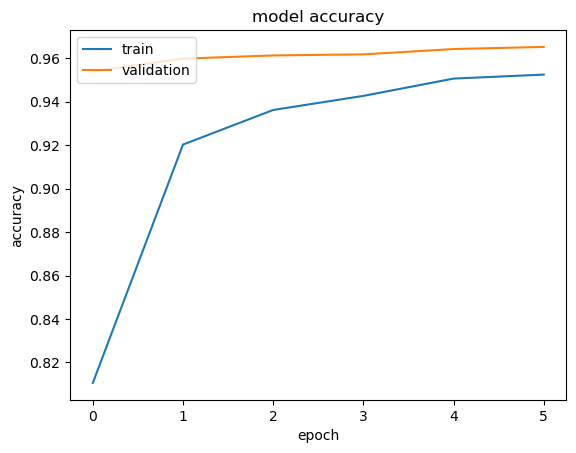

In [15]:
n_epochs = 6
learning_rate=4e-4
model = build_model(num_classes=NUM_CLASSES, learning_rate = learning_rate)

hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

Epoch 1/5
256/256 [==============================] - 220s 823ms/step - loss: 0.2253 - accuracy: 0.9603 - val_loss: 0.1944 - val_accuracy: 0.9672
Epoch 2/5
256/256 [==============================] - 208s 813ms/step - loss: 0.1988 - accuracy: 0.9645 - val_loss: 0.1789 - val_accuracy: 0.9711
Epoch 3/5
256/256 [==============================] - 212s 829ms/step - loss: 0.1850 - accuracy: 0.9630 - val_loss: 0.1678 - val_accuracy: 0.9716
Epoch 4/5
256/256 [==============================] - 214s 833ms/step - loss: 0.1721 - accuracy: 0.9696 - val_loss: 0.1614 - val_accuracy: 0.9711
Epoch 5/5
256/256 [==============================] - 211s 824ms/step - loss: 0.1556 - accuracy: 0.9713 - val_loss: 0.1533 - val_accuracy: 0.9701


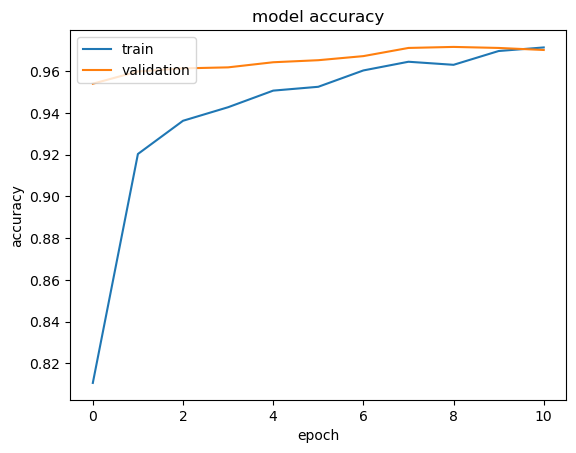

In [16]:
unfreeze_model(model, True, 5e-5)
n_epochs = 5
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

Epoch 1/6
256/256 [==============================] - 221s 827ms/step - loss: 0.1505 - accuracy: 0.9710 - val_loss: 0.1430 - val_accuracy: 0.9726
Epoch 2/6
256/256 [==============================] - 209s 814ms/step - loss: 0.1281 - accuracy: 0.9762 - val_loss: 0.1350 - val_accuracy: 0.9736
Epoch 3/6
256/256 [==============================] - 208s 810ms/step - loss: 0.1191 - accuracy: 0.9766 - val_loss: 0.1321 - val_accuracy: 0.9716
Epoch 4/6
256/256 [==============================] - 207s 808ms/step - loss: 0.1099 - accuracy: 0.9797 - val_loss: 0.1269 - val_accuracy: 0.9736
Epoch 5/6
256/256 [==============================] - 207s 808ms/step - loss: 0.1015 - accuracy: 0.9813 - val_loss: 0.1210 - val_accuracy: 0.9726
Epoch 6/6
256/256 [==============================] - 207s 808ms/step - loss: 0.0970 - accuracy: 0.9824 - val_loss: 0.1152 - val_accuracy: 0.9750


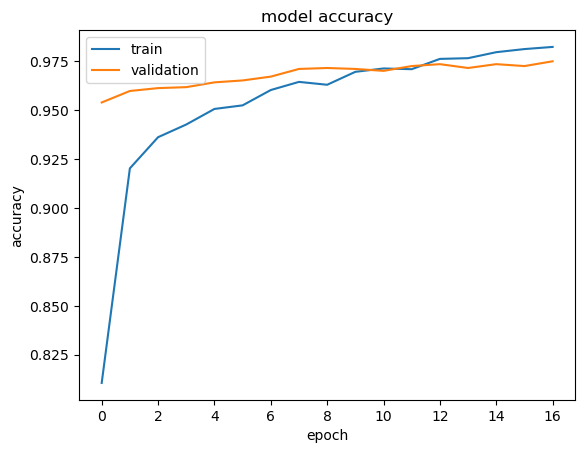

In [17]:
n_epochs = 6
learning_rate = 1e-4
model = compile_model(model, learning_rate)
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

Epoch 1/3
256/256 [==============================] - 213s 798ms/step - loss: 0.0839 - accuracy: 0.9870 - val_loss: 0.1147 - val_accuracy: 0.9750
Epoch 2/3
256/256 [==============================] - 202s 787ms/step - loss: 0.0879 - accuracy: 0.9851 - val_loss: 0.1146 - val_accuracy: 0.9750
Epoch 3/3
256/256 [==============================] - 202s 788ms/step - loss: 0.0818 - accuracy: 0.9869 - val_loss: 0.1144 - val_accuracy: 0.9750


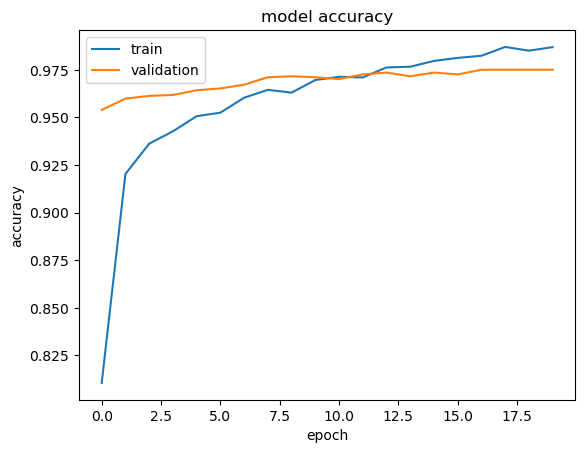

In [18]:
unfreeze_model(model, False, 1e-8)
n_epochs = 3
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

In [19]:
#history.history

In [20]:
df_test = pd.read_csv(data_dir+'/test.csv', dtype={'Id': str})
df_test['filename'] = data_dir+'/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [21]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=False
)

Found 3808 validated image filenames.


In [22]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 75s 614ms/step


In [23]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [24]:
predictions = classes[y_pred.argmax(axis=1)]

In [25]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len(data_dir+'/images/'):-4]
del df_submission['filename']

In [26]:
df_submission[['Id', 'label']].to_csv('submissions/effb2_imnet_v8_more_forks_glasses_b7.csv', index=False)

In [27]:
!kaggle competitions submit kitchenware-classification -f submissions/effb2_imnet_v8_more_forks_glasses_b7.csv -m 'validation: 0.9744'